In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util, RockingCurve

# Doc
In this implementation, I will assume that we have 1D input for everything

In [8]:
def get_bragg_reflectivity_with_phonon(kVec,
                                       thickness,
                                       BraggG,
                                       normal,
                                       phononQ,
                                       omega,
                                       polar,
                                       chi0,
                                       chih,
                                       chihbar):
    # ---------------------------------------------------
    # Get the output wave-vector
    # ---------------------------------------------------
    klen_grid = np.linalg.norm(kVec, axis=-1)

    # Define commonly used geometric quantities for the calculation
    gamma_0 = np.sum(np.multiply(kVec, normal), axis=-1) / klen_grid
    gamma_h = np.sum(np.multiply(kVec + BraggG, normal), axis=-1) / klen_grid
    b = gamma_0 / gamma_h

    alpha = (2 * np.sum(np.multiply(kVec, BraggG), axis=-1) + np.sum(np.square(BraggG), axis=-1)) / np.square(klen_grid)

    # Get surface momentrum transfer momentum tranfer 
    m_trans = np.multiply(klen_grid, -gamma_h - np.sqrt(gamma_h ** 2 - alpha))

    # Update the kout_grid
    kout = kVec + BraggG + np.multiply(m_trans[:, np.newaxis], normal)

    # -----------------------------------------------------
    # Perfect crystal
    # ------------------------------------------------------
    y = 0.5 / np.sqrt(np.abs(b).astype(np.complex128) * chih * chihbar)
    y *= b * alpha + chi0 * (1 - b)
    y1 = -y + np.sqrt(y ** 2 - 1)
    y2 = -y - np.sqrt(y ** 2 - 1)

    scriptG = np.sqrt(np.abs(b) * chih * chihbar) / chihbar
    scriptA = klen_grid * thickness * np.sqrt(chihbar * chih / gamma_0 / np.abs(gamma_h))

    eta_d_1 = chi0 * klen_grid * thickness / 2. / gamma_0 + scriptA / 2. * y1
    eta_d_2 = chi0 * klen_grid * thickness / 2. / gamma_0 + scriptA / 2. * y2

    # Create a mask that switch the 1 and 2
    mask = eta_d_1.imag < 0  # if eta_d_1.imag < 0, then (1.j * eta_d_1).real > 0 which means the exp() explodes
    tmp_eta_d = np.copy(eta_d_1)
    tmp_y = np.copy(y1)

    y1[mask] = y2[mask]
    y2[mask] = tmp_y[mask]
    eta_d_1[mask] = eta_d_2[mask]
    eta_d_2[mask] = tmp_eta_d[mask]

    capR1 = scriptG * y1
    capR2 = scriptG * y2

    phase_term = np.exp(1.j * (eta_d_1 - eta_d_2))
    R0H = capR1 * capR2 * (1 - phase_term)
    R0H /= (capR2 - capR1 * phase_term)

    R00 = (capR2 - capR1) / (capR2 - capR1 * phase_term)
    R00 *= np.exp(1.j * eta_d_1)

    # -----------------------------------------------------
    # phonon contribution
    # ------------------------------------------------------
    delta_chih = 1.j * chih * np.sum(np.multiply(BraggG, polar), axis=-1)
    delta_chihbar = 1.j * chihbar * np.sum(np.multiply(BraggG, polar), axis=-1)
    beta_h = alpha - chi0 / 2.

    capA0 = 2. / klen_grid * np.sum(np.multiply(kVec / klen_grid[:, np.newaxis], phononQ), axis=-1)
    capA0 -= 2 * omega / util.c / klen_grid

    capAh = 2. / klen_grid * np.sum(np.multiply((kVec + BraggG) / klen_grid[:, np.newaxis], phononQ), axis=-1)
    capAh -= 2 * omega / util.c / klen_grid

    d_plus = 0.5 * (chih * delta_chihbar * R0H + capA0 * delta_chih * R00)
    d_plus /= (capA0 * (capAh + 2 * beta_h) - chih * chihbar)

    d_minus = 0.5 * (chih * delta_chihbar * R0H - capA0 * delta_chih * R00)
    d_minus /= (-capA0 * (-capAh + 2 * beta_h) - chih * chihbar)

    return R0H, R00, b, d_plus, d_minus, kout, delta_chih

# Get the rough position of the peak

In [9]:
num = 2 ** 12  # Number of points to calculate
Ec = 9.8  # keV
klen = util.kev_to_wavevec_length(Ec)

# -------------------------------------------
# Get the kin array
# -------------------------------------------
wedge_angle = np.deg2rad(10)
rot_mat = util.get_rotmat_around_axis(angleRadian=np.deg2rad(3.575 * 2),
                                      axis=np.array([0, np.sin(wedge_angle), -np.cos(wedge_angle)]))

si111_angle = np.deg2rad(2 * 11.639 - 0.2)
k_vec = np.dot(rot_mat, np.array([0, - np.sin(si111_angle), np.cos(si111_angle), ]) * klen)

kin_array = np.ones(num)[:, np.newaxis] * k_vec[np.newaxis, :]

# -------------------------------------------
# Get the crystal properties
# -------------------------------------------
crystal_property = {"d": 1.3806 * 1e-4,  # um
                    "chi0": complex(-0.20135E-04, 0.63853E-06),
                    "chih": complex(0.10376E-04, -0.60756E-06),
                    "chih_pi": complex(0.60195E-05, -0.35235E-06),
                    }
# -------------------------------------------
# Get the crystal lattice array
# -------------------------------------------
g_vec = np.outer(np.ones(num), np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])

angle_scan = np.linspace(start=np.deg2rad(-3.0213 - 0.7), stop=np.deg2rad(-3.0213 + 0.7), num=num)
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

for idx in range(num):
    rot_mat = util.get_rotmat_around_axis(angleRadian=angle_scan[idx], axis=np.array([1., 0., 0.]))
    g_vec[idx] = np.dot(tilt_mat, np.dot(rot_mat, g_vec[idx]))

normal_array = np.outer(np.ones(num), np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]))
# -------------------------------------------
# Get the transient grating array and the corresponding perturbation
# -------------------------------------------
t_vec = np.outer(np.ones(num), np.array([1, 0, 0]) * klen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2.)

# Assume that we are seeing the longitudinal acoustic phonon
displace = t_vec / np.linalg.norm(t_vec, axis=-1)[:, np.newaxis] * 1e-3
omega_array = np.ones(num) * 0.5e-3  # 0.5 THz phonon

# -------------------------------------------
# Calculate the reflectivity
# -------------------------------------------
(R0H, R00, b,
 d_plus, d_minus,
 kout, delta_chih) = get_bragg_reflectivity_with_phonon(kVec=kin_array,
                                                        thickness=500.,  # um
                                                        BraggG=g_vec,
                                                        normal=normal_array,
                                                        phononQ=t_vec,
                                                        omega=omega_array,
                                                        polar=displace,
                                                        chi0=crystal_property['chi0'],
                                                        chih=crystal_property['chih'],
                                                        chihbar=crystal_property['chih'], )

# Sanity check, get the reflectivity from my old code
reflect_s, reflect_p, b_new, kout_grid = RockingCurve.get_bragg_reflectivity_per_entry(kin=kin_array,
                                                                                       thickness=500.,
                                                                                       crystal_h=g_vec,
                                                                                       normal=normal_array,
                                                                                       chi_dict=crystal_property)

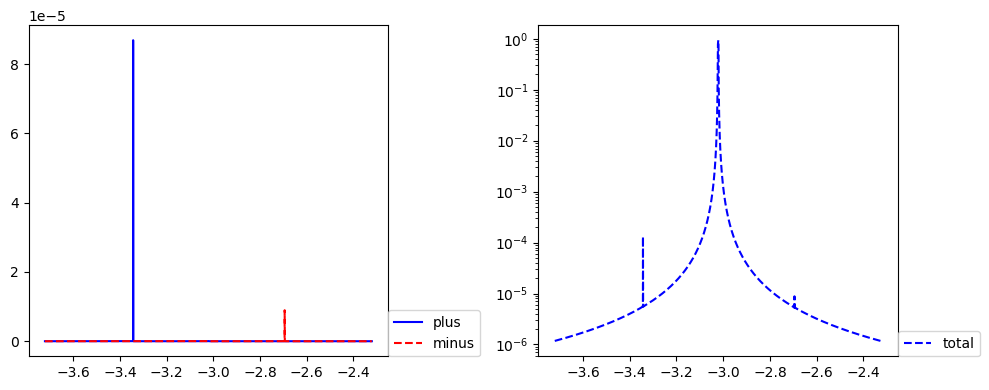

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan), np.abs(d_plus) ** 2 / np.abs(b), color='b', label='plus')
axes[0].plot(np.rad2deg(angle_scan), np.abs(d_minus) ** 2 / np.abs(b), color='r', linestyle='--', label='minus')
axes[0].legend(loc=(1,0))

#axes[1].plot(np.rad2deg(angle_scan), np.abs(d_plus + d_minus) ** 2 / np.abs(b), color='b', label='plus')
axes[1].semilogy(np.rad2deg(angle_scan), np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b), color='b', linestyle='--', label='total')
axes[1].legend(loc=(1,0))

plt.tight_layout()
plt.show()

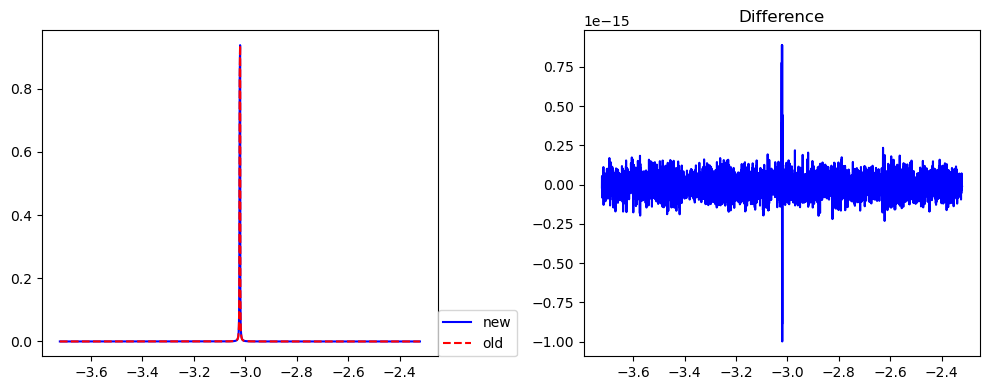

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan), np.abs(R0H) ** 2 / np.abs(b), color='b', label='new')
axes[0].plot(np.rad2deg(angle_scan), np.abs(reflect_s) ** 2 / np.abs(b), color='r', linestyle='--', label='old')
axes[0].legend(loc=(1,0))

axes[1].plot(np.rad2deg(angle_scan), np.abs(R0H) ** 2 / np.abs(b) - np.abs(reflect_s) ** 2 / np.abs(b), color='b', label='new')
axes[1].set_title("Difference")

plt.tight_layout()
plt.show()

# Get the left peak

The peak fwhm is 3.40e-05 deg centered at -2.694580 deg


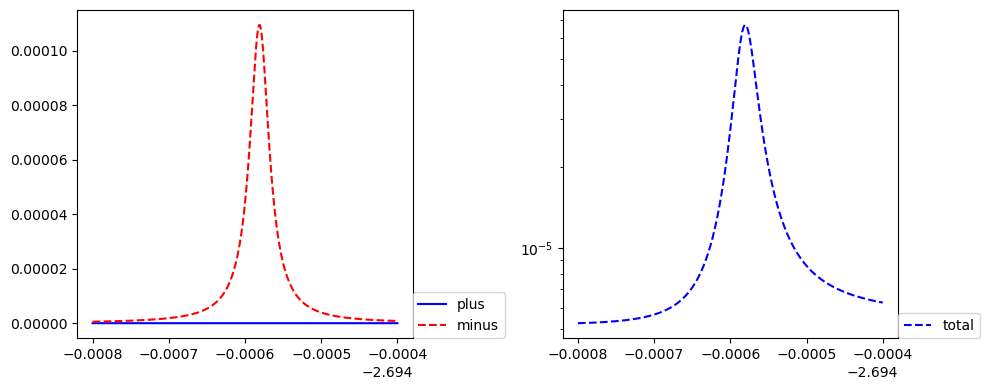

In [27]:
# -------------------------------------------
# Get the crystal lattice array
# -------------------------------------------
g_vec = np.outer(np.ones(num), np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])

angle_scan = np.linspace(start=np.deg2rad(-2.6948), stop=np.deg2rad(-2.6944), num=num)
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

for idx in range(num):
    rot_mat = util.get_rotmat_around_axis(angleRadian=angle_scan[idx], axis=np.array([1., 0., 0.]))
    g_vec[idx] = np.dot(tilt_mat, np.dot(rot_mat, g_vec[idx]))

normal_array = np.outer(np.ones(num), np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]))
# -------------------------------------------
# Get the transient grating array and the corresponding perturbation
# -------------------------------------------
t_vec = np.outer(np.ones(num), np.array([1, 0, 0]) * klen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2.)

# Assume that we are seeing the longitudinal acoustic phonon
displace = t_vec / np.linalg.norm(t_vec, axis=-1)[:, np.newaxis] * 1e-3
omega_array = np.ones(num) * 0.5e-3  # 0.5 THz phonon

# -------------------------------------------
# Calculate the reflectivity
# -------------------------------------------
(R0H, R00, b,
 d_plus, d_minus,
 kout, delta_chih) = get_bragg_reflectivity_with_phonon(kVec=kin_array,
                                                        thickness=500.,  # um
                                                        BraggG=g_vec,
                                                        normal=normal_array,
                                                        phononQ=t_vec,
                                                        omega=omega_array,
                                                        polar=displace,
                                                        chi0=crystal_property['chi0'],
                                                        chih=crystal_property['chih'],
                                                        chihbar=crystal_property['chih'], )

reflectivity = np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b)
fwhm, mean = util.get_fwhm(coordinate=angle_scan, curve_values=reflectivity, center=True)
print("The peak fwhm is {:.2e} deg centered at {:.6f} deg".format(np.rad2deg(fwhm), np.rad2deg(mean)))

#  Visualization
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan), np.abs(d_plus) ** 2 / np.abs(b), color='b', label='plus')
axes[0].plot(np.rad2deg(angle_scan), np.abs(d_minus) ** 2 / np.abs(b), color='r', linestyle='--', label='minus')
axes[0].legend(loc=(1,0))

#axes[1].plot(np.rad2deg(angle_scan), np.abs(d_plus + d_minus) ** 2 / np.abs(b), color='b', label='plus')
axes[1].semilogy(np.rad2deg(angle_scan), np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b), color='b', linestyle='--', label='total')
axes[1].legend(loc=(1,0))

plt.tight_layout()
plt.show()

The peak fwhm is 3.46e-05 deg centered at -3.343529 deg


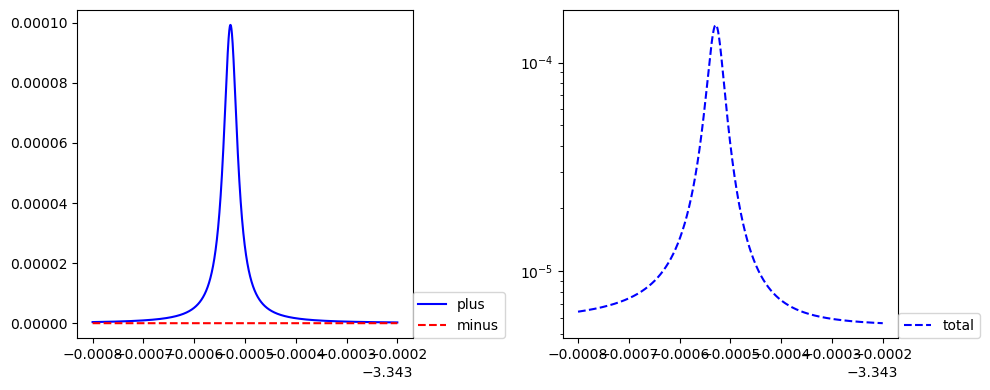

In [22]:
# -------------------------------------------
# Get the crystal lattice array
# -------------------------------------------
g_vec = np.outer(np.ones(num), np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])

angle_scan = np.linspace(start=np.deg2rad(-3.3438), stop=np.deg2rad(-3.3432), num=num)
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

for idx in range(num):
    rot_mat = util.get_rotmat_around_axis(angleRadian=angle_scan[idx], axis=np.array([1., 0., 0.]))
    g_vec[idx] = np.dot(tilt_mat, np.dot(rot_mat, g_vec[idx]))

normal_array = np.outer(np.ones(num), np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]))
# -------------------------------------------
# Get the transient grating array and the corresponding perturbation
# -------------------------------------------
t_vec = np.outer(np.ones(num), np.array([1, 0, 0]) * klen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2.)

# Assume that we are seeing the longitudinal acoustic phonon
displace = t_vec / np.linalg.norm(t_vec, axis=-1)[:, np.newaxis] * 1e-3
omega_array = np.ones(num) * 0.5e-3  # 0.5 THz phonon

# -------------------------------------------
# Calculate the reflectivity
# -------------------------------------------
(R0H, R00, b,
 d_plus, d_minus,
 kout, delta_chih) = get_bragg_reflectivity_with_phonon(kVec=kin_array,
                                                        thickness=500.,  # um
                                                        BraggG=g_vec,
                                                        normal=normal_array,
                                                        phononQ=t_vec,
                                                        omega=omega_array,
                                                        polar=displace,
                                                        chi0=crystal_property['chi0'],
                                                        chih=crystal_property['chih'],
                                                        chihbar=crystal_property['chih'], )

reflectivity = np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b)
fwhm, mean = util.get_fwhm(coordinate=angle_scan, curve_values=reflectivity, center=True)
print("The peak fwhm is {:.2e} deg centered at {:.6f} deg".format(np.rad2deg(fwhm), np.rad2deg(mean)))

#  Visualization
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan), np.abs(d_plus) ** 2 / np.abs(b), color='b', label='plus')
axes[0].plot(np.rad2deg(angle_scan), np.abs(d_minus) ** 2 / np.abs(b), color='r', linestyle='--', label='minus')
axes[0].legend(loc=(1,0))

#axes[1].plot(np.rad2deg(angle_scan), np.abs(d_plus + d_minus) ** 2 / np.abs(b), color='b', label='plus')
axes[1].semilogy(np.rad2deg(angle_scan), np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b), color='b', linestyle='--', label='total')
axes[1].legend(loc=(1,0))

plt.tight_layout()
plt.show()

The peak fwhm is 3.16e-03 deg centered at -3.021491 deg


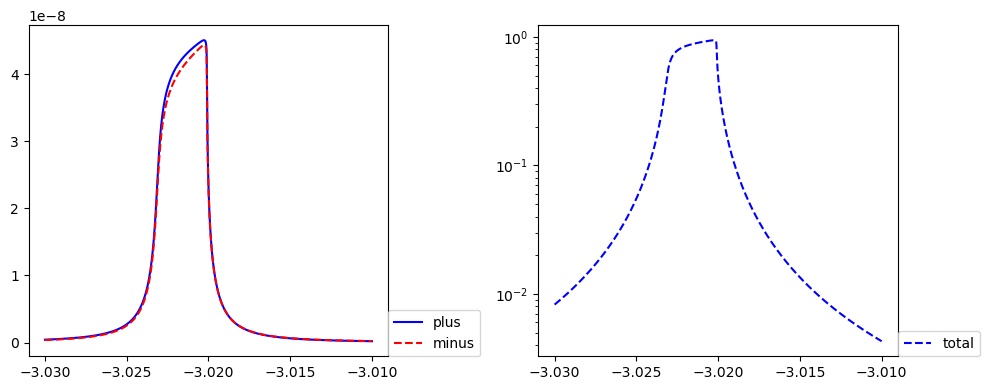

In [31]:
# -------------------------------------------
# Get the crystal lattice array
# -------------------------------------------
g_vec = np.outer(np.ones(num), np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])

angle_scan = np.linspace(start=np.deg2rad(-3.03), stop=np.deg2rad(-3.01), num=num)
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

for idx in range(num):
    rot_mat = util.get_rotmat_around_axis(angleRadian=angle_scan[idx], axis=np.array([1., 0., 0.]))
    g_vec[idx] = np.dot(tilt_mat, np.dot(rot_mat, g_vec[idx]))

normal_array = np.outer(np.ones(num), np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]))
# -------------------------------------------
# Get the transient grating array and the corresponding perturbation
# -------------------------------------------
t_vec = np.outer(np.ones(num), np.array([1, 0, 0]) * klen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2.)

# Assume that we are seeing the longitudinal acoustic phonon
displace = t_vec / np.linalg.norm(t_vec, axis=-1)[:, np.newaxis] * 1e-3
omega_array = np.ones(num) * 0.5e-3  # 0.5 THz phonon

# -------------------------------------------
# Calculate the reflectivity
# -------------------------------------------
(R0H, R00, b,
 d_plus, d_minus,
 kout, delta_chih) = get_bragg_reflectivity_with_phonon(kVec=kin_array,
                                                        thickness=500.,  # um
                                                        BraggG=g_vec,
                                                        normal=normal_array,
                                                        phononQ=t_vec,
                                                        omega=omega_array,
                                                        polar=displace,
                                                        chi0=crystal_property['chi0'],
                                                        chih=crystal_property['chih'],
                                                        chihbar=crystal_property['chih'], )

reflectivity = np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b)
fwhm, mean = util.get_fwhm(coordinate=angle_scan, curve_values=reflectivity, center=True)
print("The peak fwhm is {:.2e} deg centered at {:.6f} deg".format(np.rad2deg(fwhm), np.rad2deg(mean)))

#  Visualization
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan), np.abs(d_plus) ** 2 / np.abs(b), color='b', label='plus')
axes[0].plot(np.rad2deg(angle_scan), np.abs(d_minus) ** 2 / np.abs(b), color='r', linestyle='--', label='minus')
axes[0].legend(loc=(1,0))

#axes[1].plot(np.rad2deg(angle_scan), np.abs(d_plus + d_minus) ** 2 / np.abs(b), color='b', label='plus')
axes[1].semilogy(np.rad2deg(angle_scan), np.abs(d_plus + d_minus + R0H) ** 2 / np.abs(b), color='b', linestyle='--', label='total')
axes[1].legend(loc=(1,0))

plt.tight_layout()
plt.show()